In [3]:
import os, gc, snappy
import numpy as np
import matplotlib.pyplot as plt
from snappy import ProductIO, File, HashMap, GPF
jpy = snappy.jpy


File = jpy.get_type('java.io.File')
#archi=File('S3A_OL_1_EFR____20190615T064725_20190615T065025_20190616T105435_0179_046_020_3060_LN1_O_NT_002.SEN3')
archi=File('C:/Users/Massimo/Documents/SchoolFolder/ThirdYear/Thesis/SentinelData/2021/extra/S3B_SL_2_LST____20210616T094035_20210616T094335_20210617T190722_0179_053_307_2340_LN2_O_NT_004.SEN3')
product = ProductIO.readProduct(archi)
reader = snappy.ProductIO.getProductReader('SEN3')

In [4]:
list(product.getBandNames())

['LST_uncertainty_locATM',
 'LST_uncertainty_locGEO',
 'LST_uncertainty_locSF',
 'LST_uncertainty_locT',
 'LST_uncertainty_random',
 'LST_uncertainty_sys',
 'NDVI',
 'TCWV',
 'biome',
 'fraction',
 'LST',
 'LST_uncertainty',
 'exception',
 'x_in',
 'y_in',
 'bayes_in',
 'cloud_in',
 'confidence_in',
 'pointing_in',
 'probability_cloud_dual_in',
 'probability_cloud_single_in',
 'elevation_in',
 'latitude_in',
 'longitude_in',
 'detector_in',
 'pixel_in',
 'scan_in']

In [5]:
band = product.getBand('LST') # Assign Band to a variable
w = product.getSceneRasterWidth() # Get Band Width
h = product.getSceneRasterHeight() # Get Band Height

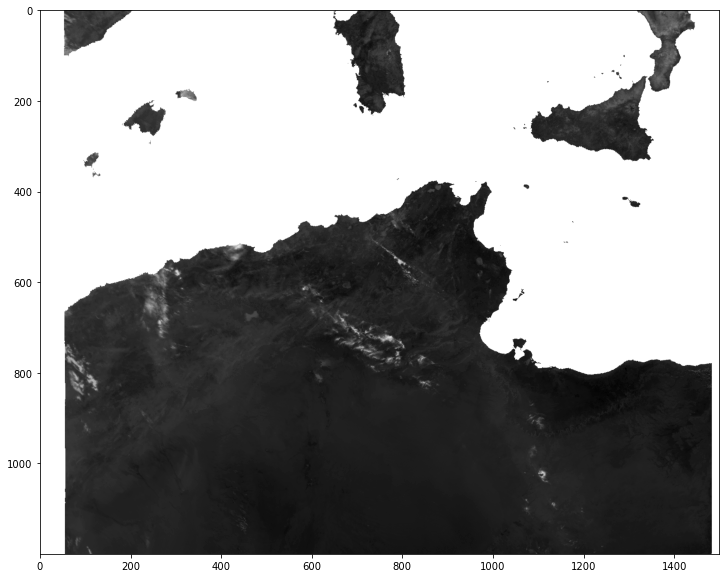

In [6]:
# Create an empty array
band_data = np.zeros(w * h, np.float32)
# Populate array with pixel value
band.readPixels(0, 0, w, h, band_data) 
# Reshape
band_data.shape = h, w
# Plot the band  
plt.figure(figsize=(18,10))
plt.imshow(band_data, cmap = plt.cm.binary)
plt.show()

In [1]:
#https://github.com/Sentinel-5P/data-on-s3/blob/master/notebooks/Sentinel3_Tutorial.ipynb
import cartopy.crs as ccrs
import rasterio
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from rasterio.plot import show


In [4]:

# For convenience I have stored the COG file in the same directory as this notebook.
# Note you may have given the file a different name.
path_pc = 'C:/Users/Massimo/Documents/SchoolFolder/SentinelData/TIF_files/S3B_SL_2_LST____20210616T094035_20210616T094335_20210617T190722_0179_053_307_2340_LN2_O_NT_004_LST.tif' 
path_laptop = 'C:/Users/Massimo/Documents/SchoolFolder/ThirdYear/Thesis/SentinelData/TIF_files/S3B_SL_2_LST____20210616T094035_20210616T094335_20210617T190722_0179_053_307_2340_LN2_O_NT_004_LST.tif'
#S3B_SL_2_LST____20210616T094035_20210616T094335_20210617T190722_0179_053_307_2340_LN2_O_NT_004_LST.tif

#when using .tif
raster = rasterio.open(path_laptop)

#when using df product


# This will print out a short version of the  meta data associated with this file.
print(raster.meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1500, 'height': 1200, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.010635999999999979, 0.0, 0.5596749999999999,
       0.0, -0.009772000000005221, 42.00366700000001)}


In [5]:
# Data visualization units.
#unit = '[ K ]'
unit = '[ °C ]'

long_name = 'Sentinel-3 Land Surface Temperature'

# We need to know the geographical extent of the data, this is contained in the raster object.

bbox = raster.bounds
extent=[bbox[0],bbox[2],bbox[1],bbox[3]]
#extent=[35.7, 36.1, 14.1, 14.6]
print (bbox)

BoundingBox(left=0.5596749999999999, bottom=30.277266999993742, right=16.513674999999967, top=42.00366700000001)


In [6]:
from rasterio.enums import Resampling

upscale_factor = 1

# resample data to target shape
data = raster.read(
out_shape=(
    raster.count,
    int(raster.height * upscale_factor),
    int(raster.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
transform = raster.transform * raster.transform.scale(
(raster.width / data.shape[-1]),
(raster.height / data.shape[-2]))

print('Rescaled size: ',np.shape(data[0,:,:]))

Rescaled size:  (1200, 1500)


C:\Users\Massimo\AppData\Local\Temp/ipykernel_5960/2899018059.py:20: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  color.set_bad('white')


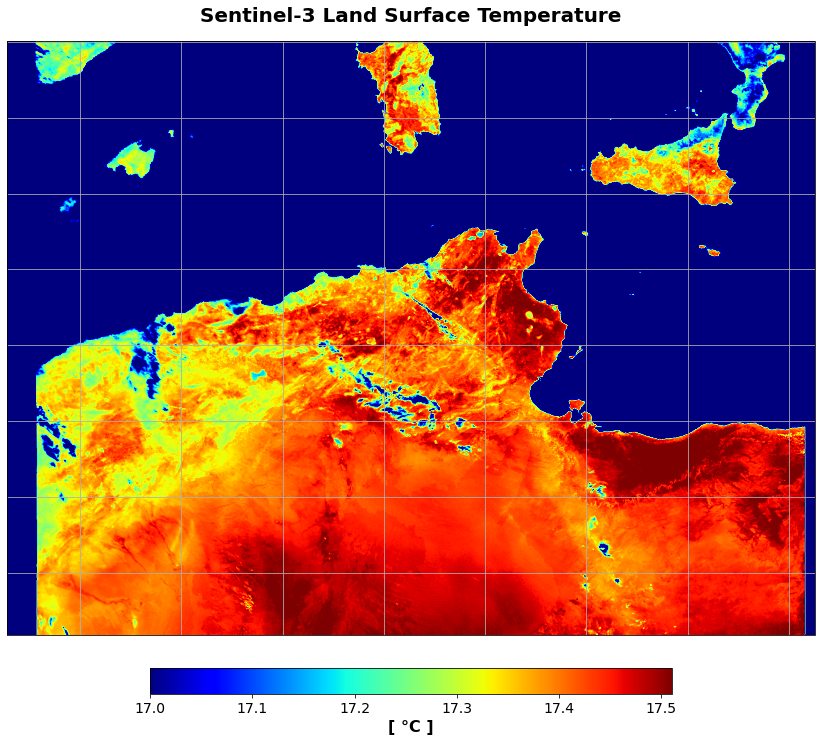

In [7]:
# Here we set up the parameters needed to display the geographical data correctly.
fig=plt.figure(figsize=(15, 12))

# Here we set up a simple Plate Carree geographical projection. This is handled by the Cartopy library.
#proj = ccrs.epsg(3857)
#ax = plt.axes(projection=proj)
ax = plt.axes(projection=ccrs.PlateCarree())

# The coastline data get downloaded here, there may be a delay the first time you run this notebook.

#ax.coastlines(resolution='10m')
ax.gridlines()
ax.set_title(long_name, fontsize=20, pad=20.0, fontweight = 'bold')

# Here we set the colour map for matplotlib. e.g. 'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'jet', also
# selecting which colour to associate with the NODATA value in the map

color = cm.jet

color.set_bad('white')

#The pixel associated to the NODATA values are masked out.

data = data.astype(np.float16)
data[data == -32768.0] = np.nan

# As the product contains the data in Digital Numbers (DN), it is necessary to calibrate them with the SCALE FACTOR and OFFSET values.
# These can be retrieved from the extended metadata of the file. 

scale_factor = 0.0020000001

offset = 290

cal_data = scale_factor * data - 273 + offset

img = plt.imshow(cal_data[0,:,:], cmap = color,extent = extent,transform=ccrs.PlateCarree())

cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.05)
cbar.set_label(unit, fontsize=16, fontweight = 'bold')
cbar.ax.tick_params(labelsize=14)
plt.savefig('lst.png')
plt.show()

C:\Users\Massimo\AppData\Local\Temp/ipykernel_5960/1943286488.py:2: UserWarning: The default value for the *approx* keyword argument to OSNI will change from True to False after 0.18.
  ax = plt.axes(projection=ccrs.OSNI())


Text(0.5, 1.0, 'Sentinel-3 Land Surface Temperature')

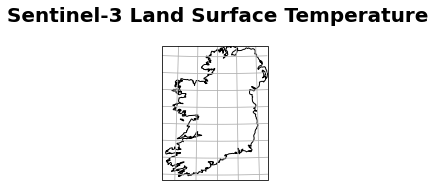

In [8]:
plt.figure(figsize=(2, 3))
ax = plt.axes(projection=ccrs.OSNI())
ax.coastlines(resolution='10m')
ax.gridlines()
ax.set_title(long_name, fontsize=20, pad=20.0, fontweight = 'bold')
